In [1]:
import pandas as pd
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Case I - Cancelamentos de Reserva

Construir dois modelos para prever o cancelamento de reservas:

- O primeiro é para um cliente que vive uma realidade de dados muito rudimentar. Logo, o modelo precisa ser simples, de forma a aprofundar o entendimento do cliente sobre o fenômeno modelado.
- O segundo é para um cliente que tem uma infrasetrutura de dados extremamente desenvolvida. O modelo será utilizado para fazer previsões no momento de cada reserva, estimando a probabilidade de cancelamento desta.

https://www.sciencedirect.com/science/article/pii/S2352340918315191

In [93]:
tb_hotel = pd.read_csv('data/tb_hotel_traintest.csv')
tb_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113409 entries, 0 to 113408
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           113409 non-null  object 
 1   is_cancelled                    113409 non-null  int64  
 2   lead_time                       113409 non-null  int64  
 3   stays_in_weekend_nights         113409 non-null  int64  
 4   stays_in_week_nights            113409 non-null  int64  
 5   adults                          113409 non-null  int64  
 6   children                        113406 non-null  float64
 7   babies                          113409 non-null  int64  
 8   meal                            113409 non-null  object 
 9   country                         112951 non-null  object 
 10  market_segment                  113409 non-null  object 
 11  distribution_channel            113409 non-null  object 
 12  is_repeated_gues

## Exercício I

A primeira etapa na construção de um modelo é a etapa de formulação de hipóteses a respeito do fenômeno que queremos modelar. Embora o avanço da disponibilidade de capacidade computacional e de dados coletados nos permita adotar uma metodologia que parte de uma exploração direta do dataset, neste exercicio buscaremos trabalhar a formulação de hipóteses independente dos dados.

O objetivo é formular hipóteses sobre os fatores e mecânismos que aumentam ou diminuem a probabilidade de uma reserva ser cancelada. Podemos utilizar uma metodologia como os 5-Porques (https://en.wikipedia.org/wiki/Five_whys) para facilitar e nos guiar nesse processo, mas esse é um exercício de devaneio e imaginação!!

**As respostas estão no .txt "case I - analise de hipoteses"**

## Visualizando os dados

<AxesSubplot:xlabel='lead_time', ylabel='Count'>

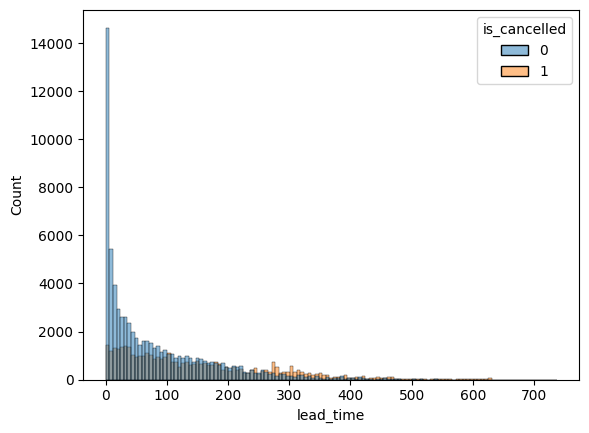

In [3]:
sns.histplot(data=tb_hotel, x='lead_time', hue='is_cancelled')

Histogramas não são bons de visualizar dados desbalanceados, a visão é mais focada no comportamento individual da variável. Melhor usar um boxplot pois a visão é do ponto de vista dos quartis, ou seja, temos uma visão do comportamento do agrupamento das variáveis, assim o gráfico além de fornecer mais informações, não fica poluido e confuso.

<AxesSubplot:xlabel='is_cancelled', ylabel='lead_time'>

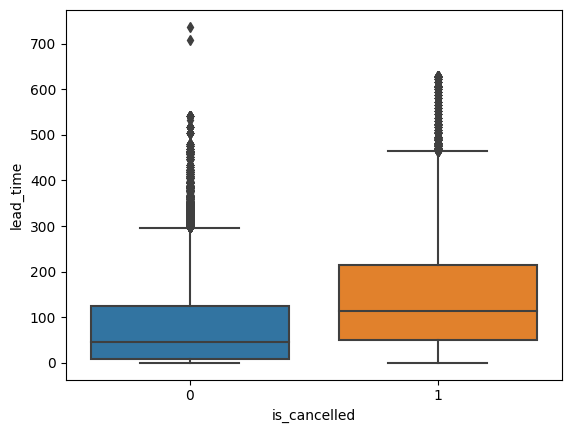

In [4]:
sns.boxplot(data=tb_hotel, y='lead_time', x='is_cancelled') # Melhor de visualizar classes desbalanceadas.

<AxesSubplot:xlabel='lead_time', ylabel='Density'>

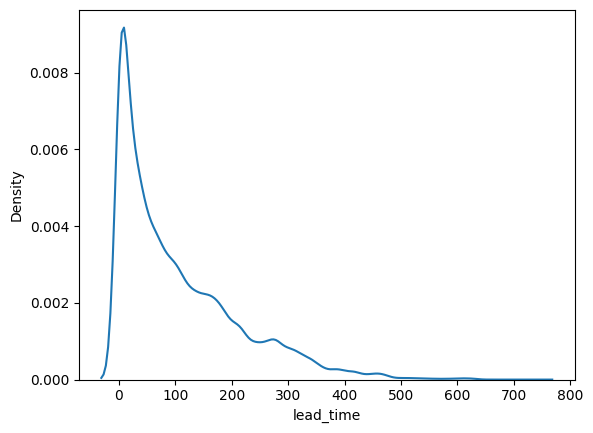

In [5]:
sns.kdeplot(data=tb_hotel, x='lead_time')

## Analisando o impacto do Lead Time nos cancelamentos usando Regressão Logística 

In [94]:
model = LogisticRegression()
model.fit(tb_hotel[['lead_time']], tb_hotel['is_cancelled'])
tb_hotel['pred_is_cancelled_RL'] = model.predict_proba(tb_hotel[['lead_time']])[:,1]

In [7]:
model.predict_proba(tb_hotel[['lead_time']])[:,1]

array([0.69842564, 0.95917118, 0.24506141, ..., 0.27552691, 0.37125247,
       0.50905894])

<AxesSubplot:xlabel='lead_time', ylabel='pred_is_cancelled_RL'>

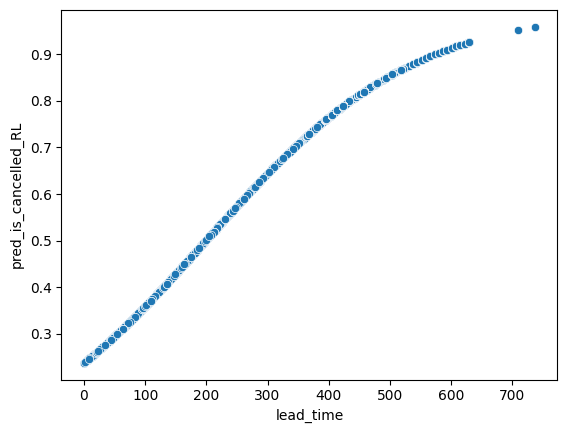

In [8]:
sns.scatterplot(data=tb_hotel, x='lead_time', y='pred_is_cancelled_RL')

Observamos que de fato a chance de cancelamentos cresce à medida que o Lead Time aumenta. **Mas atenção às bordas da curva:** Na borda inferior por exemplo, por que temos cancelamentos em Lead Time = 0? É erro do modelo? Esses dados existem no Dataset? Vamos analisar:

#### Primeiro verificando no Dataset se existem variáveis onde há cancelamentos em Lead Time = 0

In [9]:
cancelamentos_na_hora = tb_hotel.loc[(tb_hotel['lead_time'] == 0) & (tb_hotel['is_cancelled'] == 1)]

In [10]:
tb_hotel.loc[(tb_hotel['lead_time'] == 0) & (tb_hotel['is_cancelled'] == 0)].shape # 5596 não cancelamentos na hora. 

(5596, 30)

In [11]:
cancelamentos_na_hora # 401 Cancelamentos na hora.

,hotel,is_cancelled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,arrival_date,id_booking,pred_is_cancelled_RL
418,Resort Hotel,1,0,0,1,2,0.0,0,BB,PRT,...,NaN,0,Transient,123.2,0,0,2015-07-16,2015-07-16,438,0.237545
481,Resort Hotel,1,0,0,1,2,0.0,0,BB,PRT,...,NaN,0,Transient,136.0,0,0,2015-07-17,2015-07-17,504,0.237545
763,Resort Hotel,1,0,0,1,1,0.0,0,BB,PRT,...,270.0,0,Transient,114.0,0,0,2015-07-30,2015-07-30,796,0.237545
872,Resort Hotel,1,0,0,1,2,0.0,0,BB,PRT,...,NaN,0,Transient,172.0,0,1,2015-08-05,2015-08-05,909,0.237545
1596,Resort Hotel,1,0,0,1,1,0.0,0,BB,PRT,...,NaN,0,Transient,146.0,0,2,2015-09-09,2015-09-09,1673,0.237545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93851,City Hotel,1,0,1,0,2,0.0,0,BB,PRT,...,NaN,0,Transient,77.0,0,2,2016-12-12,2016-12-12,98809,0.237545
93852,City Hotel,1,0,1,0,2,0.0,0,BB,PRT,...,NaN,0,Transient,0.0,0,2,2016-12-12,2016-12-12,98810,0.237545
96819,City Hotel,1,0,0,1,2,0.0,0,BB,PRT,...,NaN,0,Transient,0.0,0,0,2017-06-29,2017-06-29,101930,0.237545
100598,City Hotel,1,0,0,1,1,0.0,0,BB,PRT,...,45.0,0,Transient,0.0,0,2,2017-04-18,2017-04-18,105909,0.237545


In [12]:
cancelamentos_na_hora['country'].value_counts() # Obvio que a maioria seriam Portugueses

PRT    324
FRA     12
ESP      8
GBR      5
USA      4
AGO      4
DEU      4
BRA      3
BEL      3
CN       2
SWE      2
ITA      2
NLD      2
RUS      2
ECU      1
ZAF      1
AZE      1
BLR      1
AUT      1
SVK      1
MAR      1
POL      1
IRL      1
ROU      1
KOR      1
Name: country, dtype: int64

In [13]:
cancelamentos_na_hora['company'].isna().sum() # Reservas não coorporativas

347

### Aqui observamos a existência de reservas com 0 adultos, crianças e bebês. O que podem ser dados inválidos.

In [14]:
cancelamentos_na_hora[['adults', 'children', 'babies']].value_counts() / cancelamentos_na_hora.shape[0]

adults  children  babies
2       0.0       0         0.603491
1       0.0       0         0.294264
0       0.0       0         0.029925
3       0.0       0         0.024938
2       1.0       0         0.019950
        2.0       0         0.012469
3       1.0       0         0.007481
2       2.0       1         0.004988
        0.0       1         0.002494
dtype: float64

In [15]:
tb_hotel[['adults', 'children', 'babies']].value_counts() / tb_hotel.shape[0]

adults  children  babies
2       0.0       0         0.683138
1       0.0       0         0.188618
3       0.0       0         0.047606
2       1.0       0         0.033322
        2.0       0         0.026938
        0.0       1         0.005917
3       1.0       0         0.004127
1       1.0       0         0.002310
0       2.0       0         0.001764
        0.0       0         0.001473
1       2.0       0         0.001287
2       1.0       1         0.001146
4       0.0       0         0.000520
2       3.0       0         0.000503
3       2.0       0         0.000335
2       2.0       1         0.000238
        0.0       2         0.000106
0       3.0       0         0.000097
3       0.0       1         0.000079
1       0.0       1         0.000079
26      0.0       0         0.000044
1       3.0       0         0.000035
0       1.0       0         0.000035
2       1.0       2         0.000026
0       2.0       1         0.000026
20      0.0       0         0.000018
27      0.0  

<AxesSubplot:xlabel='deposit_type', ylabel='Count'>

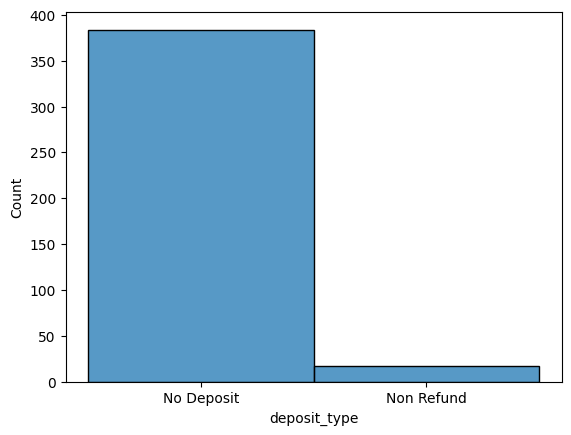

In [16]:
cancelamentos_na_hora['deposit_type'].value_counts()
sns.histplot(data=cancelamentos_na_hora, x='deposit_type')

In [17]:
cancelamentos_na_hora['adr'].value_counts()

0.00      40
109.00    29
89.00     19
12.00     17
8.00      13
          ..
207.00     1
174.00     1
168.00     1
205.33     1
77.00      1
Name: adr, Length: 150, dtype: int64

### Atenção aqui:
Aqui o objetivo era analisar se nos cancelamentos em Lead Time = 0, o tipo de hotel tinha alguma relação. Nesses casos é importante analisar tanto a distribuição da subamostra em questão e comparar com a distribuição do Dataset completo para ver se há alguma diferença.

Nesse caso em particular, não teve :P. Be Careful!

<AxesSubplot:xlabel='hotel', ylabel='Count'>

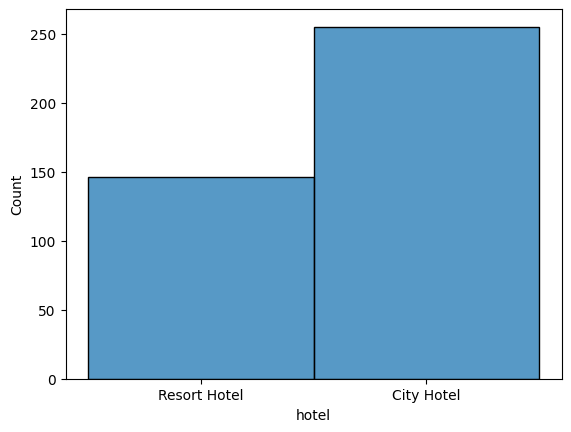

In [18]:
cancelamentos_na_hora['hotel'].value_counts()
sns.histplot(data=cancelamentos_na_hora, x='hotel')

<AxesSubplot:xlabel='hotel', ylabel='Count'>

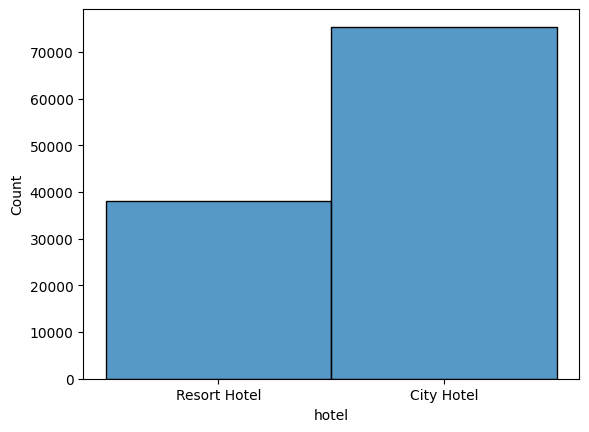

In [19]:
sns.histplot(data=tb_hotel, x='hotel')

/tmp/ipykernel_1684/697820624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancelamentos_na_hora['stays_total'] = cancelamentos_na_hora['stays_in_weekend_nights'] + cancelamentos_na_hora['stays_in_week_nights']


<AxesSubplot:xlabel='stays_total', ylabel='Count'>

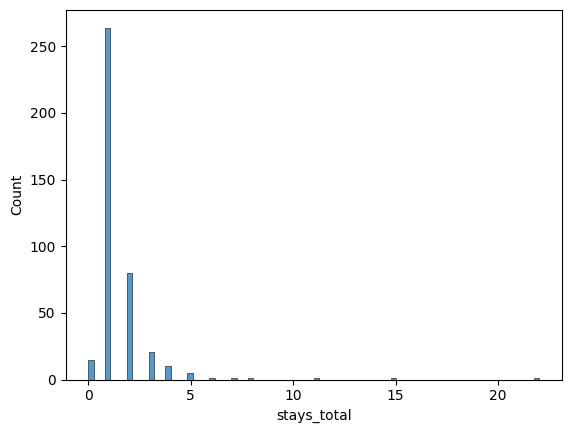

In [20]:
# Analisando a distribuição do total de dias da estadia em Lead Time = 0
# Pelo visto, na grande maioria das vezes é apenas 1 dia.
cancelamentos_na_hora['stays_total'] = cancelamentos_na_hora['stays_in_weekend_nights'] + cancelamentos_na_hora['stays_in_week_nights']
cancelamentos_na_hora['stays_total'].value_counts()
sns.histplot(data=cancelamentos_na_hora, x='stays_total')

<AxesSubplot:xlabel='stays_total', ylabel='Count'>

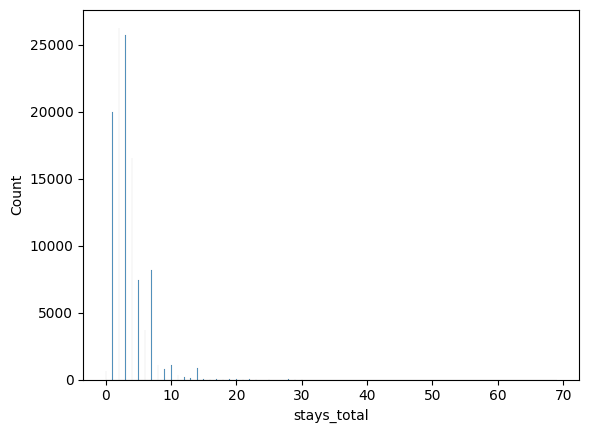

In [21]:
# Novamente comparamos com a distribuição do dataset para ver se há diferença! 
# Dessa ves houve diferença sim! Parece que estadias com mais de 1 dia tbm são comuns no dataset, então as distribuições tem características diferentes sim!
tb_hotel['stays_total'] = tb_hotel['stays_in_weekend_nights'] + tb_hotel['stays_in_week_nights']
tb_hotel['stays_total'].value_counts()
sns.histplot(data=tb_hotel, x='stays_total')

In [22]:
# Analisando cancelamentos onde não há adultos presentes, apenas crianças. Parecem dados inválidos. Nesse caso, iremos removê-los no futuro.
cancelamentos_fantasmas = cancelamentos_na_hora.loc[(cancelamentos_na_hora['adults'] == 0) & (cancelamentos_na_hora['children'] == 0.0) & (cancelamentos_na_hora['babies'] == 0)]
cancelamentos_fantasmas

,hotel,is_cancelled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,arrival_date,id_booking,pred_is_cancelled_RL,stays_total
3923,Resort Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2016-02-15,2016-02-15,4127,0.237545,0
57608,City Hotel,1,0,4,11,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2016-11-17,2016-11-17,60651,0.237545,15
58167,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2016-12-06,2016-12-06,61244,0.237545,0
58168,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2016-12-06,2016-12-06,61245,0.237545,0
58172,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2016-12-06,2016-12-06,61249,0.237545,0
61537,City Hotel,1,0,0,3,0,0.0,0,BB,PRT,...,0,Transient,0.0,0,0,2017-03-16,2017-03-16,64782,0.237545,3
62601,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2017-04-10,2017-04-10,65907,0.237545,0
62602,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2017-04-10,2017-04-10,65908,0.237545,0
62603,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2017-04-10,2017-04-10,65909,0.237545,0
62604,City Hotel,1,0,0,0,0,0.0,0,SC,NaN,...,0,Transient,0.0,0,0,2017-04-10,2017-04-10,65910,0.237545,0


# Dividindo a distribuição em Quantis:

In [23]:
# Observamos extensivamente variáveis independentes do nosso dataset filtrando por cancelamentos em lead time = 0
# Agora iremos fatiar a distribuição em quantis para melhor analisar esses tempos.
lead_time_curto = tb_hotel.loc[(tb_hotel['lead_time'] == 0) & (tb_hotel['is_cancelled'] == 1)]

**Uso do pd.qcut:** Útil para <i>discretizar</i> dados de uma coluna, isto é, agrupa os dados em intervalos fixos (quantis) onde nós determinamos essa quantidade de grupos. Nisso temos uma coluna de valores inteiros ou categóricos (discretos) baseado numa coluna de valores contínuos.

In [95]:
q = 10
tb_hotel['cat_lead_time'] = pd.qcut(tb_hotel['lead_time'], q, labels=[str(i) for i in range(1, 11)]) # Aqui nós criamos a coluna cat_lead_time com a discretização de lead_time.
tb_hotel['cat_lead_time']

0         10
1         10
2          2
3          3
4          3
          ..
113404     3
113405     7
113406     4
113407     7
113408     9
Name: cat_lead_time, Length: 113409, dtype: category
Categories (10, object): ['1' < '2' < '3' < '4' ... '7' < '8' < '9' < '10']

In [25]:
# Ratio é a razão entre a quantidade de amostras de uma categoria (q_cat) e as amostras do dataset, ambos em relação a nossa variável resposta is_cancelled.
# É interpretado como: Qual a taxa de cancelamentos na categoria q_cat?
q_cat = '1'
q1_ratio = tb_hotel.loc[(tb_hotel['cat_lead_time'] == q_cat) & (tb_hotel['is_cancelled'] == 1)].shape[0] / tb_hotel['is_cancelled'].shape[0]
q1_ratio
# resposta para q_cat = 1 (primeiro quantil): 0.0095, super pequena, o que é esperado.

0.009549506652911145

In [26]:
# Aqui, agrupamos a média de cancelamentos por cada categoria (quantil) de **Lead Time**!
# Bom, não me parece a média de cancelamentos, e sim a média de elementos em cada categoria de Lead Time. (Perguntar do Pedro!)
tb_hotel.groupby('cat_lead_time')['is_cancelled'].mean()

cat_lead_time
1     0.083500
2     0.159411
3     0.285714
4     0.358924
5     0.383482
6     0.407999
7     0.432777
8     0.466201
9     0.474881
10    0.673058
Name: is_cancelled, dtype: float64

In [27]:
# Aqui começamos a construir uma tabela para relacionar as médias dos cancelamentos observados no dataset (is_cancelled) e as médias das predições de cancelamentos feitos pela nossa primeira 
# Regressão Logística sem dividir o dataset em Quantis (pred_is_cancelled_RL). E agrupando tudo pelas categorias de Lead Time.
is_canc_comparison = tb_hotel.groupby('cat_lead_time')[['is_cancelled', 'pred_is_cancelled_RL']].mean().reset_index()
is_canc_comparison

,cat_lead_time,is_cancelled,pred_is_cancelled_RL
0,1,0.083500,0.238562
1,2,0.159411,0.245133
2,3,0.285714,0.258172
3,4,0.358924,0.277895
4,5,0.383482,0.303787
5,6,0.407999,0.338578
6,7,0.432777,0.384374
7,8,0.466201,0.445024
8,9,0.474881,0.531382
9,10,0.673058,0.691394


In [28]:
# Agora vamos subtrair esses valores para entender o quanto o nosso modelo de RL errou em relação aos valores observados
is_canc_comparison['diff_pred'] = is_canc_comparison['is_cancelled'] - is_canc_comparison['pred_is_cancelled_RL']

### Exercício de Fixação:

Treinar uma RL para cada categoria (temos 10!), depois adicionar os resultados da predição na **is_canc_comparison** criando uma coluna com (tb_cat[pred_lead_time_cat]). Calcular e analisar o diff_pred em relação ao resutado desses dois modelos e observar os ganhos dos grupos, se foram muito significativos ou não.

### Tabela is_canc_comparison:
Os dados estão segmentados em 10 categorias e relacionamos os scores de cancelamentos observados (is_cancelled) com os cancelamentos predizidos por uma regressão logística sem segmentação de categorias (pred_is_cancelled_RL).

Calculamos a diferença entre eles (diff_pred) para visualizar os ganhos.

In [29]:
is_canc_comparison

,cat_lead_time,is_cancelled,pred_is_cancelled_RL,diff_pred
0,1,0.083500,0.238562,-0.155062
1,2,0.159411,0.245133,-0.085722
2,3,0.285714,0.258172,0.027542
3,4,0.358924,0.277895,0.081029
4,5,0.383482,0.303787,0.079695
5,6,0.407999,0.338578,0.069420
6,7,0.432777,0.384374,0.048403
7,8,0.466201,0.445024,0.021176
8,9,0.474881,0.531382,-0.056501
9,10,0.673058,0.691394,-0.018336


## Treinando a Regressão Logística para as categorias que criamos

In [30]:
tb_hotel_cat = pd.DataFrame()

In [31]:
for cat in tb_hotel['cat_lead_time'].unique():
    tb_cat = tb_hotel[tb_hotel['cat_lead_time'] == cat].copy()
    model_cat = LogisticRegression()
    model_cat.fit(tb_cat[['lead_time']], tb_cat['is_cancelled'])
    tb_cat['pred_is_cancelled_cat_RL'] = model_cat.predict_proba(tb_cat[['lead_time']])[:,1]
    tb_hotel_cat = pd.concat((tb_hotel_cat, tb_cat), axis=0)

In [32]:
tb_hotel_cat # Tabela com o resultado da Regressão por categoria

,hotel,is_cancelled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,arrival_date,id_booking,pred_is_cancelled_RL,stays_total,cat_lead_time,pred_is_cancelled_cat_RL
0,Resort Hotel,0,342,0,0,2,0.0,0,BB,PRT,...,0.00,0,0,2015-07-01,2015-07-01,0,0.698426,0,10,0.672943
1,Resort Hotel,0,737,0,0,2,0.0,0,BB,PRT,...,0.00,0,0,2015-07-01,2015-07-01,1,0.959171,0,10,0.825615
80,Resort Hotel,1,368,3,7,2,0.0,0,BB,PRT,...,55.68,0,0,2015-05-19,2015-07-03,81,0.729545,10,10,0.684899
81,Resort Hotel,0,364,3,7,2,0.0,0,BB,GBR,...,55.68,0,0,2015-07-13,2015-07-03,82,0.724891,10,10,0.683075
84,Resort Hotel,0,324,4,10,2,0.0,0,HB,GBR,...,134.73,0,0,2015-07-17,2015-07-03,85,0.675734,14,10,0.664531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113366,City Hotel,0,149,0,4,2,0.0,0,BB,ESP,...,84.60,0,0,2017-09-03,2017-08-30,119343,0.427459,4,8,0.469902
113391,City Hotel,0,175,1,3,2,0.0,0,BB,NLD,...,86.85,0,2,2017-09-04,2017-08-31,119371,0.465125,4,8,0.464666
113392,City Hotel,0,175,1,3,1,0.0,0,BB,NLD,...,82.35,0,1,2017-09-04,2017-08-31,119372,0.465125,4,8,0.464666
113395,City Hotel,0,165,1,5,3,0.0,0,BB,AUT,...,209.25,0,3,2017-09-04,2017-08-29,119376,0.450567,6,8,0.466679


<AxesSubplot:xlabel='lead_time', ylabel='pred_is_cancelled_RL'>

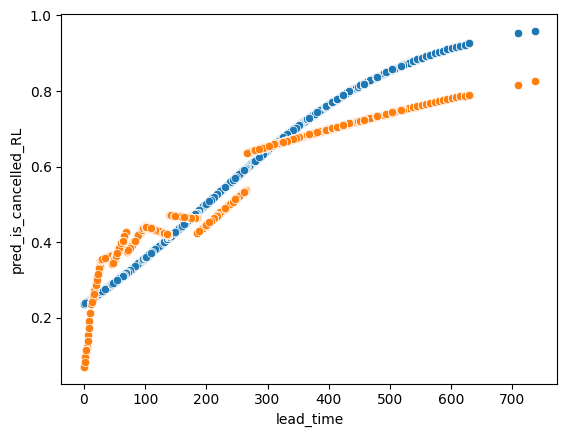

In [33]:
# Visualizando graficamente as predições da regressão sem separar em categorias e separando em categorias.
sns.scatterplot(data=tb_hotel_cat, x='lead_time', y='pred_is_cancelled_RL')
sns.scatterplot(data=tb_hotel_cat, x='lead_time', y='pred_is_cancelled_cat_RL') # Cria varias retinhas que são as predições por categoria <3

In [34]:
# Calcula a média dos resultados das predições por categoria e agrupa pela categoria!
results_cat = tb_hotel_cat.groupby('cat_lead_time')['pred_is_cancelled_cat_RL'].mean().reset_index()
results_cat

,cat_lead_time,pred_is_cancelled_cat_RL
0,1,0.083500
1,2,0.159411
2,3,0.285714
3,4,0.358924
4,5,0.383483
5,6,0.407998
6,7,0.431087
7,8,0.467461
8,9,0.474881
9,10,0.672253


In [35]:
# Adiciona à nossa tabela de comparação!
is_canc_comparison['pred_is_cancelled_cat_RL'] = results_cat['pred_is_cancelled_cat_RL'].values

In [36]:
is_canc_comparison

,cat_lead_time,is_cancelled,pred_is_cancelled_RL,diff_pred,pred_is_cancelled_cat_RL
0,1,0.083500,0.238562,-0.155062,0.083500
1,2,0.159411,0.245133,-0.085722,0.159411
2,3,0.285714,0.258172,0.027542,0.285714
3,4,0.358924,0.277895,0.081029,0.358924
4,5,0.383482,0.303787,0.079695,0.383483
5,6,0.407999,0.338578,0.069420,0.407998
6,7,0.432777,0.384374,0.048403,0.431087
7,8,0.466201,0.445024,0.021176,0.467461
8,9,0.474881,0.531382,-0.056501,0.474881
9,10,0.673058,0.691394,-0.018336,0.672253


In [37]:
# Agora calculamos a diferença entre os cancelamentos observados e as predições por categoria!
# E essa é a resposta do exercício de fixação 1
is_canc_comparison['diff_pred_cat'] = is_canc_comparison['is_cancelled'] - is_canc_comparison['pred_is_cancelled_cat_RL']
is_canc_comparison

,cat_lead_time,is_cancelled,pred_is_cancelled_RL,diff_pred,pred_is_cancelled_cat_RL,diff_pred_cat
0,1,0.083500,0.238562,-0.155062,0.083500,-9.585790e-09
1,2,0.159411,0.245133,-0.085722,0.159411,-7.037117e-09
2,3,0.285714,0.258172,0.027542,0.285714,3.002080e-07
3,4,0.358924,0.277895,0.081029,0.358924,3.547036e-09
4,5,0.383482,0.303787,0.079695,0.383483,-7.312493e-07
5,6,0.407999,0.338578,0.069420,0.407998,3.033470e-07
6,7,0.432777,0.384374,0.048403,0.431087,1.690215e-03
7,8,0.466201,0.445024,0.021176,0.467461,-1.260001e-03
8,9,0.474881,0.531382,-0.056501,0.474881,2.803198e-08
9,10,0.673058,0.691394,-0.018336,0.672253,8.046587e-04


### Interpretação da resposta 1
- O modelo por categorias foi muito melhor, inclusive overfitou rs. Parece que as RLs são muito boas em acertar a média de distribuições! 

In [38]:
is_canc_comparison

,cat_lead_time,is_cancelled,pred_is_cancelled_RL,diff_pred,pred_is_cancelled_cat_RL,diff_pred_cat
0,1,0.083500,0.238562,-0.155062,0.083500,-9.585790e-09
1,2,0.159411,0.245133,-0.085722,0.159411,-7.037117e-09
2,3,0.285714,0.258172,0.027542,0.285714,3.002080e-07
3,4,0.358924,0.277895,0.081029,0.358924,3.547036e-09
4,5,0.383482,0.303787,0.079695,0.383483,-7.312493e-07
5,6,0.407999,0.338578,0.069420,0.407998,3.033470e-07
6,7,0.432777,0.384374,0.048403,0.431087,1.690215e-03
7,8,0.466201,0.445024,0.021176,0.467461,-1.260001e-03
8,9,0.474881,0.531382,-0.056501,0.474881,2.803198e-08
9,10,0.673058,0.691394,-0.018336,0.672253,8.046587e-04


### Analisando q = 4

In [39]:
q = 4
tb_hotel['cat_lead_time'] = pd.qcut(tb_hotel['lead_time'], q, labels=[str(i) for i in range(1, q+1)])
# tb_hotel_4['cat_lead_time'] = pd.qcut(tb_hotel['lead_time'], q, labels=[str(i) for i in range(1, q+1)]) 

In [40]:
is_canc_comparison_4 = tb_hotel.groupby('cat_lead_time')[['is_cancelled', 'pred_is_cancelled_RL']].mean().reset_index()
is_canc_comparison_4['diff_pred'] = is_canc_comparison_4['is_cancelled'] - is_canc_comparison_4['pred_is_cancelled_RL']
is_canc_comparison_4

# Ainda conseguimos observar que o erro é maior na primeira categoria e menor na ultima.

,cat_lead_time,is_cancelled,pred_is_cancelled_RL,diff_pred
0,1,0.145775,0.243963,-0.098188
1,2,0.358993,0.284861,0.074131
2,3,0.427219,0.374811,0.052408
3,4,0.554407,0.581390,-0.026983


In [41]:
tb_hotel2 = pd.DataFrame()
for cat in tb_hotel['cat_lead_time'].unique():
    tb_cat = tb_hotel[tb_hotel['cat_lead_time'] == cat].copy()
    model3 = LogisticRegression()
    model3.fit(tb_cat[['lead_time']], tb_cat['is_cancelled'])
    tb_cat['pred_is_cancelled_cat_RL'] = model3.predict_proba(tb_cat[['lead_time']])[:,1]
    tb_hotel2 = pd.concat((tb_hotel2, tb_cat), axis=0)

is_canc_comparison_4['pred_is_cancelled_cat_RL'] = tb_hotel2['pred_is_cancelled_cat_RL']
is_canc_comparison_4['diff_pred_cat'] = is_canc_comparison_4['is_cancelled'] - is_canc_comparison_4['pred_is_cancelled_cat_RL']
is_canc_comparison_4

,cat_lead_time,is_cancelled,pred_is_cancelled_RL,diff_pred,pred_is_cancelled_cat_RL,diff_pred_cat
0,1,0.145775,0.243963,-0.098188,0.650115,-0.504340
1,2,0.358993,0.284861,0.074131,0.922482,-0.563490
2,3,0.427219,0.374811,0.052408,0.145364,0.281855
3,4,0.554407,0.581390,-0.026983,0.232652,0.321755


<AxesSubplot:xlabel='lead_time', ylabel='pred_is_cancelled_RL'>

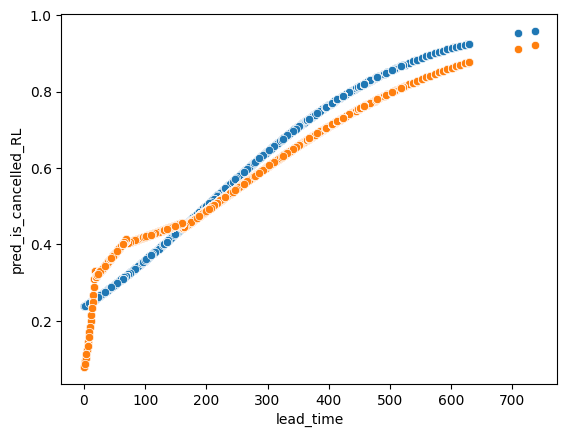

In [42]:
sns.scatterplot(data=tb_hotel2, x='lead_time', y='pred_is_cancelled_RL')
sns.scatterplot(data=tb_hotel2, x='lead_time', y='pred_is_cancelled_cat_RL')

In [43]:
import numpy as np
q = 70
tb_hotel2['cat_lead_time'] = pd.cut(tb_hotel2['lead_time'], q)
results7 = tb_hotel2.groupby('cat_lead_time')[['is_cancelled', 'pred_is_cancelled_RL','pred_is_cancelled_cat_RL']].mean().reset_index()
results7['pred_diff'] = np.abs(results7['is_cancelled'] - results7['pred_is_cancelled_RL'])
results7

,cat_lead_time,is_cancelled,pred_is_cancelled_RL,pred_is_cancelled_cat_RL,pred_diff
0,"(-0.737, 10.529]",0.111798,0.241000,0.109233,0.129202
1,"(10.529, 21.057]",0.260998,0.254579,0.272412,0.006419
2,"(21.057, 31.586]",0.332004,0.266901,0.329646,0.065103
3,"(31.586, 42.114]",0.363106,0.278785,0.349086,0.084320
4,"(42.114, 52.643]",0.357203,0.291338,0.369613,0.065864
...,...,...,...,...,...
65,"(684.357, 694.886]",NaN,NaN,NaN,NaN
66,"(694.886, 705.414]",NaN,NaN,NaN,NaN
67,"(705.414, 715.943]",0.000000,0.952232,0.912530,0.952232
68,"(715.943, 726.471]",NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='pred_diff'>

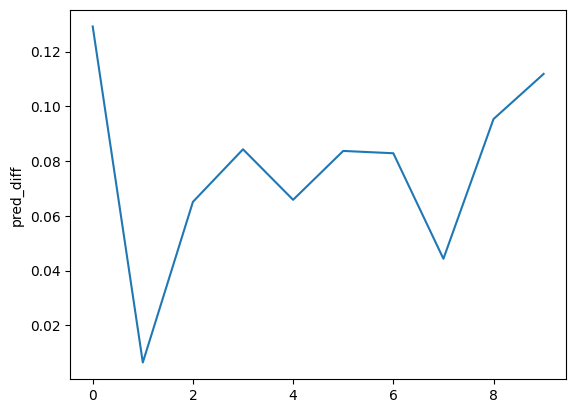

In [44]:
sns.lineplot(data=results7.iloc[:10,:], x=results7.iloc[:10,:].index, y='pred_diff')

# Exercício de fixação
- Criar um algoritmo para encontrar um ponto P que divida o lead time em duas partes e que eu possa facilmente "reencontrá-lo" ao lidar com um novo dataset.
- Explicar qualitativamente por que existe um comportamento quando LT < P e outro totalmente diferente quando LT > P (explicar do ponto de vista do problema "ah, esse fenômeno acontece porque o cliente está com urgência e etc...")
- Construir a regressão usando L1 e L2 e plotar (spoiler for spline regressions :P)

# Encontrando o ponto P

(Ou, achar o 'cotovelo' do gráfico)

Aqui, tive a idéia de subtrair a média dos cancelamentos observados [is_cancelled] de uma categoria pela seguinte e dizer que a maior das diferenças é o ponto de corte. 

Mais tarde veremos que o ideal não é pegar o **maior** valor das diferenças e sim o **primeiro menor** valor :P

In [45]:
is_canc_comparison

,cat_lead_time,is_cancelled,pred_is_cancelled_RL,diff_pred,pred_is_cancelled_cat_RL,diff_pred_cat
0,1,0.083500,0.238562,-0.155062,0.083500,-9.585790e-09
1,2,0.159411,0.245133,-0.085722,0.159411,-7.037117e-09
2,3,0.285714,0.258172,0.027542,0.285714,3.002080e-07
3,4,0.358924,0.277895,0.081029,0.358924,3.547036e-09
4,5,0.383482,0.303787,0.079695,0.383483,-7.312493e-07
5,6,0.407999,0.338578,0.069420,0.407998,3.033470e-07
6,7,0.432777,0.384374,0.048403,0.431087,1.690215e-03
7,8,0.466201,0.445024,0.021176,0.467461,-1.260001e-03
8,9,0.474881,0.531382,-0.056501,0.474881,2.803198e-08
9,10,0.673058,0.691394,-0.018336,0.672253,8.046587e-04


<AxesSubplot:ylabel='is_cancelled'>

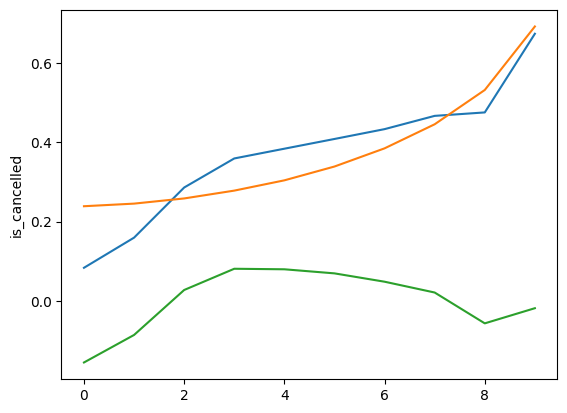

In [72]:
sns.lineplot(data=is_canc_comparison, x=is_canc_comparison.index, y=is_canc_comparison['is_cancelled']) # Azul
sns.lineplot(data=is_canc_comparison, x=is_canc_comparison.index, y=is_canc_comparison['pred_is_cancelled_RL']) # Laranja
sns.lineplot(data=is_canc_comparison, x=is_canc_comparison.index, y=is_canc_comparison['diff_pred']) # Verde
    

In [73]:

# Diferença entre as categorias de is_cancelled, lembrando que os valores são médias!
mean_canc = is_canc_comparison['is_cancelled']
lmc = len(mean_canc)
diffs = []
for cat in range(0, lmc):
    if cat + 1 < lmc:
        diffs.append(abs(mean_canc[cat] - mean_canc[cat+1]))
        print(f"cat{cat+1} - cat{cat+2} {abs(mean_canc[cat] - mean_canc[cat+1])}")

print(f"\n{sorted(diffs)[::-1]}") # Ordenando decrescente as diferenças entre os cancelamentos médios


cat1 - cat2 0.07591095544384097
cat2 - cat3 0.12630294476543316
cat3 - cat4 0.07320948110185782
cat4 - cat5 0.02455865841201227
cat5 - cat6 0.024516186726385725
cat6 - cat7 0.02477826831829999
cat7 - cat8 0.03342379217451297
cat8 - cat9 0.008680760891834005
cat9 - cat10 0.1981766242725122

[0.1981766242725122, 0.12630294476543316, 0.07591095544384097, 0.07320948110185782, 0.03342379217451297, 0.02477826831829999, 0.02455865841201227, 0.024516186726385725, 0.008680760891834005]


A maior diferença entre as médias de cancelamentos é entre as ultimas categorias(9 - 10), porém não iremos considerar pois sabemos que a ultima categoria foi influenciada por outliers.

A segunda maior diferença entre as médias, é a da categoria 2 com a 3, parece mais confiável.

#### [Pós correção do prof.]

A idéia é boa mas eu deveria ter considerado a **primeira menor** diferença, que é onde começa a mudança de estado, pois ela que representa melhor essa mudança brusca no comportamento dos dados.

Por exemplo, isso acontece na diferença das categorias 4 - 5 ( 0.02455865841201227), e veremos que isso vai se repetindo nas análises seguintes...

In [75]:

# Diferença entre as categorias de diff_pred
mean_canc = is_canc_comparison['diff_pred']
lmc = len(mean_canc)
diffs = []
for cat in range(0, lmc):
    if cat + 1 < lmc:
        diffs.append(abs(abs(mean_canc[cat]) - abs(mean_canc[cat+1])))
        print(f"cat{cat+1} - cat{cat+2} {abs(abs(mean_canc[cat]) - abs(mean_canc[cat+1]))}")

diffs = sorted(diffs)[::-1]
print(f"\n{diffs}") # Ordenando decrescente as diferenças entre os diff_preds médios
chosen_diff = diffs[1]

cat1 - cat2 0.06933965513329854
cat2 - cat3 0.05817961626683943
cat3 - cat4 0.053486741346880806
cat4 - cat5 0.0013341392637548632
cat5 - cat6 0.010274769081629886
cat6 - cat7 0.021017106657221785
cat7 - cat8 0.02722678030357617
cat8 - cat9 0.035324571331792454
cat9 - cat10 0.03816515129301551

[0.06933965513329854, 0.05817961626683943, 0.053486741346880806, 0.03816515129301551, 0.035324571331792454, 0.02722678030357617, 0.021017106657221785, 0.010274769081629886, 0.0013341392637548632]


De novo aqui, agora olhando as médias de diff_pred por categoria procurando pelo **menor** valor, a diferença entre as categorias 4 - 5 mostra o início da mudança de estado (0.0013341392637548632).

## Segunda abordagem:

Tratando a coluna como uma distribuição e analisando a diferença entre cada categoria em relação ao desvio padrão

In [49]:
amostra = is_canc_comparison['diff_pred']
print(f"amostra:\n{amostra}")
std_amostra = np.std(amostra)
print(f"std_amostra: {std_amostra}\n")
diffs = []

for i in range(0, len(amostra)):
    diffs.append(abs(abs(amostra[i])-std_amostra))
    print(f"cat {i+1}: {abs(abs(amostra[i])-std_amostra)}")

print(max(diffs))

amostra:
0   -0.155062
1   -0.085722
2    0.027542
3    0.081029
4    0.079695
5    0.069420
6    0.048403
7    0.021176
8   -0.056501
9   -0.018336
Name: diff_pred, dtype: float64
std_amostra: 0.07496233676017558

cat 1: 0.08009939244627826
cat 2: 0.010759737312979717
cat 3: 0.04741987895385971
cat 4: 0.006066862393021094
cat 5: 0.004732723129266231
cat 6: 0.005542045952363656
cat 7: 0.02655915260958544
cat 8: 0.05378593291316161
cat 9: 0.018461361581369157
cat 10: 0.056626512874384666
0.08009939244627826


## Escolhendo o ponto P de corte e fazendo Spline manualmente:

Aqui vamos testar alguns pontos de corte, começando por um corte na categoria 3 e treinando as regressões logísticas.

Também será mostrado duas formas de fazer spline manualmente:
- A primeira é guardando as partições do dataset em variáveis diferentes e treinando uma regressão para cada partição.
- E a outra é manipulando a coluna de categorias para que linhas == L1 sejam L1 e caso contrário linhas == 0 e o mesmo para L2. E no fim também treinando a regressão para cada partição.

In [117]:
q = 4
tb_hotel['cat_lead_time'] = pd.qcut(tb_hotel['lead_time'], q, labels=[str(i) for i in range(1, q+1)])

In [118]:
tb_hotel['cat_lead_time']

0         4
1         4
2         1
3         1
4         1
         ..
113404    2
113405    3
113406    2
113407    3
113408    4
Name: cat_lead_time, Length: 113409, dtype: category
Categories (4, object): ['1' < '2' < '3' < '4']

In [119]:
# Preenchendo L1 com as categorias até o ponto de corte.

cut_point = 3
L1 = tb_hotel.loc[tb_hotel['cat_lead_time'].isin([str(i) for i in range(1, cut_point+1)])].copy() # Gerando as colunas categoricas até o ponto de corte
L1

,hotel,is_cancelled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,arrival_date,id_booking,pred_is_cancelled_RL,cat_lead_time,cat_lead_time_num,L1,L2,EA,pred_lead_time_cat,pred_is_cancelled_SRL
2,Resort Hotel,0,7,0,1,1,0.0,0,BB,GBR,...,2015-07-01,2,0.245061,1,2,7.0,0.0,1.0,0.141791,0.141791
3,Resort Hotel,0,13,0,1,1,0.0,0,BB,GBR,...,2015-07-01,3,0.251631,1,3,13.0,0.0,1.0,0.203023,0.203023
4,Resort Hotel,0,14,0,2,2,0.0,0,BB,GBR,...,2015-07-01,4,0.252737,1,3,14.0,0.0,1.0,0.214950,0.214950
5,Resort Hotel,0,14,0,2,2,0.0,0,BB,GBR,...,2015-07-01,5,0.252737,1,3,14.0,0.0,1.0,0.214950,0.214950
6,Resort Hotel,0,0,0,2,2,0.0,0,BB,PRT,...,2015-07-01,6,0.237545,1,1,0.0,0.0,1.0,0.090656,0.090656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113403,City Hotel,0,21,2,5,2,0.0,0,BB,BEL,...,2017-08-30,119384,0.260569,2,3,21.0,0.0,1.0,0.312129,0.312129
113404,City Hotel,0,23,2,5,2,0.0,0,BB,BEL,...,2017-08-30,119385,0.262836,2,3,23.0,0.0,1.0,0.343925,0.343925
113405,City Hotel,0,102,2,5,3,0.0,0,BB,FRA,...,2017-08-31,119386,0.361720,3,7,0.0,102.0,0.0,0.415847,0.415847
113406,City Hotel,0,34,2,5,2,0.0,0,BB,DEU,...,2017-08-31,119387,0.275527,2,4,0.0,34.0,0.0,0.355190,0.355190


In [120]:
# Preenchendo L2 com as categorias após o ponto de corte até a ultima.

L2 = tb_hotel.loc[tb_hotel['cat_lead_time'].isin([str(i) for i in range(cut_point+1, len(tb_hotel['cat_lead_time'].unique())+1)])].copy() # Gerando as colunas categoricas do ponto de corte até a ultima categoria
L2

,hotel,is_cancelled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,arrival_date,id_booking,pred_is_cancelled_RL,cat_lead_time,cat_lead_time_num,L1,L2,EA,pred_lead_time_cat,pred_is_cancelled_SRL
0,Resort Hotel,0,342,0,0,2,0.0,0,BB,PRT,...,2015-07-01,0,0.698426,4,10,0.0,342.0,0.0,0.637678,0.637678
1,Resort Hotel,0,737,0,0,2,0.0,0,BB,PRT,...,2015-07-01,1,0.959171,4,10,0.0,737.0,0.0,0.886454,0.886454
80,Resort Hotel,1,368,3,7,2,0.0,0,BB,PRT,...,2015-07-03,81,0.729545,4,10,0.0,368.0,0.0,0.660015,0.660015
81,Resort Hotel,0,364,3,7,2,0.0,0,BB,GBR,...,2015-07-03,82,0.724891,4,10,0.0,364.0,0.0,0.656621,0.656621
84,Resort Hotel,0,324,4,10,2,0.0,0,HB,GBR,...,2015-07-03,85,0.675734,4,10,0.0,324.0,0.0,0.621852,0.621852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113396,City Hotel,0,185,1,4,2,0.0,0,SC,CHE,...,2017-08-30,119377,0.479744,4,9,0.0,185.0,0.0,0.493297,0.493297
113397,City Hotel,0,247,1,3,2,0.0,0,BB,GBR,...,2017-08-31,119378,0.570181,4,9,0.0,247.0,0.0,0.551570,0.551570
113400,City Hotel,0,188,2,3,2,0.0,0,BB,DEU,...,2017-08-31,119381,0.484137,4,9,0.0,188.0,0.0,0.496125,0.496125
113402,City Hotel,0,164,2,4,2,0.0,0,BB,DEU,...,2017-08-31,119383,0.449115,4,8,0.0,164.0,0.0,0.473521,0.473521


In [121]:
df_l1 = pd.DataFrame()

l1_model = LogisticRegression()
l1_model.fit(L1[['lead_time']], L1['is_cancelled'])
L1['pred_is_cancelled_cat_L1'] = l1_model.predict_proba(L1[['lead_time']])[:,1]
df_l1 = pd.concat((df_l1, L1), axis=0)

results_l1 = df_l1.groupby('cat_lead_time')['is_cancelled', 'pred_is_cancelled_cat_L1'].mean().reset_index()
results_l1['diff_pred'] = results_l1['is_cancelled'] - results_l1['pred_is_cancelled_cat_L1']
results_l1

/tmp/ipykernel_1684/1344321379.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results_l1 = df_l1.groupby('cat_lead_time')['is_cancelled', 'pred_is_cancelled_cat_L1'].mean().reset_index()


,cat_lead_time,is_cancelled,pred_is_cancelled_cat_L1,diff_pred
0,1,0.145775,0.208487,-0.062712
1,2,0.358993,0.278023,0.080970
2,3,0.427219,0.444119,-0.016899
3,4,NaN,NaN,NaN


In [122]:
df_l2 = pd.DataFrame()

l2_model = LogisticRegression()
l2_model.fit(L2[['lead_time']], L2['is_cancelled'])
L2['pred_is_cancelled_cat_L2'] = l2_model.predict_proba(L2[['lead_time']])[:,1]
df_l2 = pd.concat((df_l2, L2), axis=0)

results_l2 = df_l2.groupby('cat_lead_time')['is_cancelled', 'pred_is_cancelled_cat_L2'].mean().reset_index()
results_l2['diff_pred'] = results_l2['is_cancelled'] - results_l2['pred_is_cancelled_cat_L2']
results_l2

/tmp/ipykernel_1684/3583608333.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results_l2 = df_l2.groupby('cat_lead_time')['is_cancelled', 'pred_is_cancelled_cat_L2'].mean().reset_index()


,cat_lead_time,is_cancelled,pred_is_cancelled_cat_L2,diff_pred
0,1,NaN,NaN,NaN
1,2,NaN,NaN,NaN
2,3,NaN,NaN,NaN
3,4,0.554407,0.554407,8.037480e-10


<AxesSubplot:xlabel='lead_time', ylabel='pred_is_cancelled_cat_L1'>

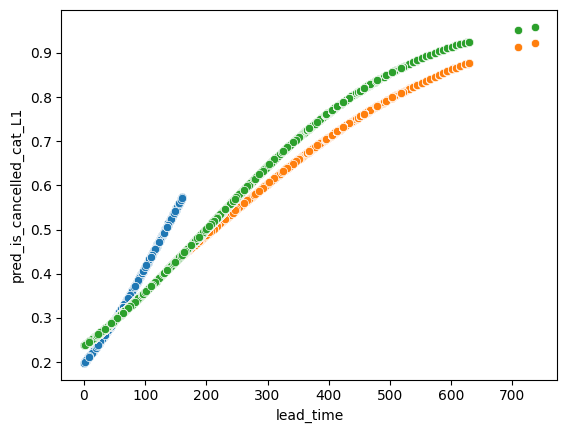

In [123]:
sns.scatterplot(data=df_l1, x='lead_time', y='pred_is_cancelled_cat_L1')
sns.scatterplot(data=df_l2, x='lead_time', y='pred_is_cancelled_cat_L2')
sns.scatterplot(data=tb_hotel, x='lead_time', y='pred_is_cancelled_RL')

In [133]:
is_canc_comparison_4

,cat_lead_time,is_cancelled,pred_is_cancelled_RL,diff_pred,pred_is_cancelled_cat_RL,diff_pred_cat
0,1,0.145775,0.243963,-0.098188,0.650115,-0.504340
1,2,0.358993,0.284861,0.074131,0.922482,-0.563490
2,3,0.427219,0.374811,0.052408,0.145364,0.281855
3,4,0.554407,0.581390,-0.026983,0.232652,0.321755


In [128]:
# Aqui criamos uma coluna com as categorias numéricas para maior facilidade em particionar os dados dentro do próprio dataframe.
tb_hotel['cat_lead_time_num'] = tb_hotel['cat_lead_time'].astype(int)

In [107]:
tb_hotel.columns

Index(['hotel', 'is_cancelled', 'lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date', 'arrival_date', 'id_booking',
       'pred_is_cancelled_RL', 'cat_lead_time', 'cat_lead_time_num', 'L1',
       'L2', 'EA'],
      dtype='object')

In [111]:
tb_hotel[['cat_lead_time_num','L1']]

,cat_lead_time_num,L1
0,10,0.0
1,10,0.0
2,2,7.0
3,3,13.0
4,3,14.0
...,...,...
113404,3,23.0
113405,7,0.0
113406,4,0.0
113407,7,0.0


In [129]:
cut_point = 3

# Se 'cat_lead_time_num' menor que o ponto de corte, preenche L1 com lead_time, senão, preenche com 0.
tb_hotel.loc[tb_hotel['cat_lead_time_num'] <= cut_point, 'L1'] = tb_hotel['lead_time'] 
tb_hotel.loc[tb_hotel['cat_lead_time_num'] > cut_point, 'L1'] = 0

# Se 'cat_lead_time_num' maior que o ponto de corte, preenche L2 com lead_time, senão, preenche com 0.
tb_hotel.loc[tb_hotel['cat_lead_time_num'] > cut_point, 'L2'] = tb_hotel['lead_time']
tb_hotel.loc[tb_hotel['cat_lead_time_num'] <= cut_point, 'L2'] = 0

# Se 'cat_lead_time_num' menor que o ponto de corte, preenche EA (intercepto adicional) com 1, senão, preenche com 0.
tb_hotel.loc[tb_hotel['cat_lead_time_num'] <= cut_point, 'EA'] = 1
tb_hotel.loc[tb_hotel['cat_lead_time_num'] > cut_point, 'EA'] = 0

In [134]:
# Treinamos a RL apenas passando as colunas

l2_model = LogisticRegression()
l2_model.fit(tb_hotel[['L1', 'L2', 'EA']], tb_hotel['is_cancelled'])
tb_hotel['pred_is_cancelled_SRL'] = l2_model.predict_proba(tb_hotel[['L1', 'L2', 'EA']])[:,1]

results_l2 = tb_hotel.groupby('cat_lead_time')['is_cancelled', 'pred_is_cancelled_SRL'].mean().reset_index()
results_l2['diff_pred'] = results_l2['is_cancelled'] - results_l2['pred_is_cancelled_SRL']
results_l2

/tmp/ipykernel_1684/3739050081.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results_l2 = tb_hotel.groupby('cat_lead_time')['is_cancelled', 'pred_is_cancelled_SRL'].mean().reset_index()


,cat_lead_time,is_cancelled,pred_is_cancelled_SRL,diff_pred
0,1,0.145775,0.208496,-0.062720
1,2,0.358993,0.278030,0.080963
2,3,0.427219,0.444118,-0.016898
3,4,0.554407,0.554392,0.000015


<AxesSubplot:xlabel='lead_time', ylabel='pred_is_cancelled_RL'>

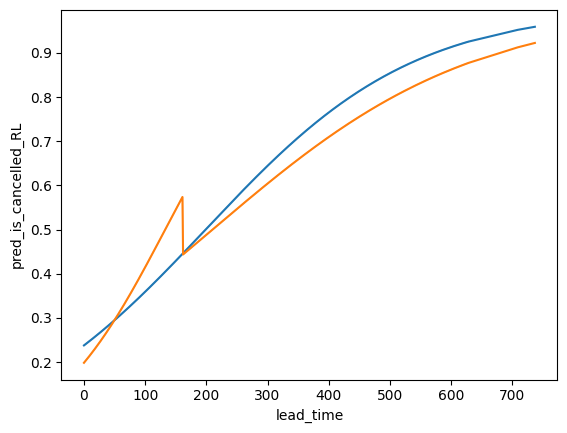

In [131]:
sns.lineplot(data=tb_hotel, x='lead_time', y='pred_is_cancelled_RL')
sns.lineplot(data=tb_hotel, x='lead_time', y='pred_is_cancelled_SRL')

<AxesSubplot:xlabel='lead_time', ylabel='pred_is_cancelled_RL'>

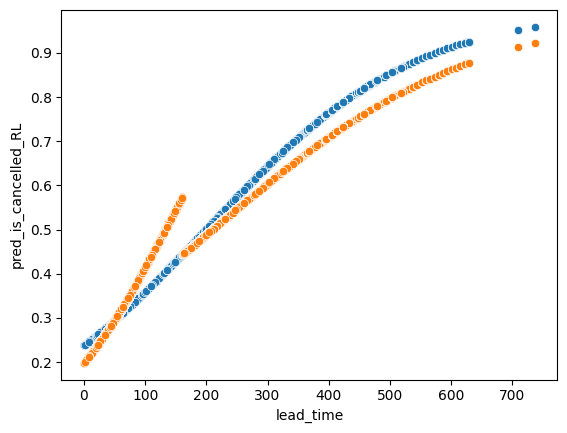

In [60]:
sns.scatterplot(data=tb_hotel, x='lead_time', y='pred_is_cancelled_RL')
sns.scatterplot(data=tb_hotel, x='lead_time', y='pred_lead_time_cat')

# Proximas atividades

- Experimentar o uso de modelos não lineares (Decision Trees, Boosting, Ensemble, Random Forests, NNs) ainda com o Lead Time, comparar com a RL comum e a RL Splines. A comparação será por análise de Confusion Matrix observando erros Tipo 2.
- Considerar apenas as instancias classificadas incorretamente e sugerir os próximos passos para a predição correta destas, talvez considerando outras colunas da tabela, Talvez criando novos parâmetros como fizemos o segundo intersecto 'EA'.


## Experimentando Decision Trees:

In [136]:
tb_hotel['is_cancelled'].unique()

array([0, 1])

In [137]:
X = np.array(tb_hotel['lead_time'])
y = tb_hotel['is_cancelled']


X = X.reshape(-1, 1)
print(X)

tree_model = DecisionTreeClassifier(max_depth=2, class_weight="balanced")
tree_model.fit(X,y)

[[342]
 [737]
 [  7]
 ...
 [ 34]
 [109]
 [205]]


DecisionTreeClassifier(class_weight='balanced', max_depth=2)

In [138]:
export_graphviz(tree_model,
                out_file="hotel_balanced_10.dot",
                feature_names=['lead_time'],
                class_names=[str(x) for x in tb_hotel['is_cancelled'].unique()],
                rounded=True,
                filled=True)

In [139]:
predictions = tree_model.predict_proba(X)[:,1]

In [140]:
tb_hotel['pred_is_cancelled_DT'] = predictions

<AxesSubplot:xlabel='lead_time', ylabel='pred_is_cancelled_DT'>

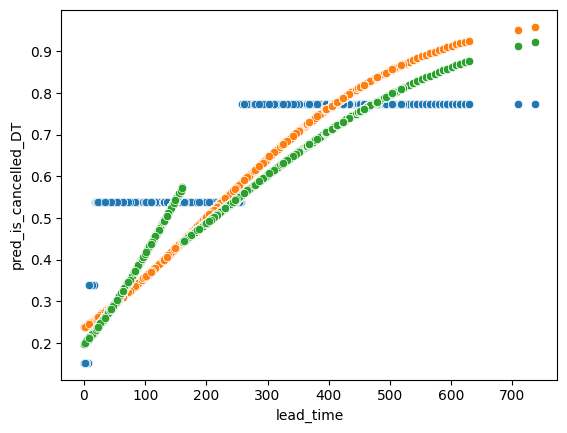

In [141]:
sns.scatterplot(data=tb_hotel, x='lead_time', y="pred_is_cancelled_DT")
sns.scatterplot(data=tb_hotel, x='lead_time', y='pred_is_cancelled_RL')
sns.scatterplot(data=tb_hotel, x='lead_time', y='pred_is_cancelled_SRL')

In [142]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


boost_model = CatBoostClassifier(depth = 2, 
                                od_type = 'Iter', 
                                od_wait = 300, 
                                iterations = 10000)

boost_model.fit(X_train, y_train, eval_set=(X_test, y_test))


Learning rate set to 0.033919
0:	learn: 0.6867961	test: 0.6869287	best: 0.6869287 (0)	total: 16.3ms	remaining: 2m 43s
1:	learn: 0.6813484	test: 0.6815896	best: 0.6815896 (1)	total: 22.3ms	remaining: 1m 51s
2:	learn: 0.6760363	test: 0.6764179	best: 0.6764179 (2)	total: 27ms	remaining: 1m 30s
3:	learn: 0.6709561	test: 0.6714020	best: 0.6714020 (3)	total: 38.9ms	remaining: 1m 37s
4:	learn: 0.6659439	test: 0.6664657	best: 0.6664657 (4)	total: 43.2ms	remaining: 1m 26s
5:	learn: 0.6615761	test: 0.6622081	best: 0.6622081 (5)	total: 45.8ms	remaining: 1m 16s
6:	learn: 0.6572411	test: 0.6579231	best: 0.6579231 (6)	total: 54.2ms	remaining: 1m 17s
7:	learn: 0.6534853	test: 0.6542731	best: 0.6542731 (7)	total: 57ms	remaining: 1m 11s
8:	learn: 0.6500222	test: 0.6508997	best: 0.6508997 (8)	total: 62.5ms	remaining: 1m 9s
9:	learn: 0.6467576	test: 0.6477084	best: 0.6477084 (9)	total: 66.8ms	remaining: 1m 6s
10:	learn: 0.6435665	test: 0.6445550	best: 0.6445550 (10)	total: 70.3ms	remaining: 1m 3s
11:	lea

In [68]:
tb_hotel['pred_is_cancelled_BOO'] = boost_model.predict_proba(tb_hotel[["lead_time"]])[:,1]

<AxesSubplot:xlabel='lead_time', ylabel='pred_is_cancelled_DT'>

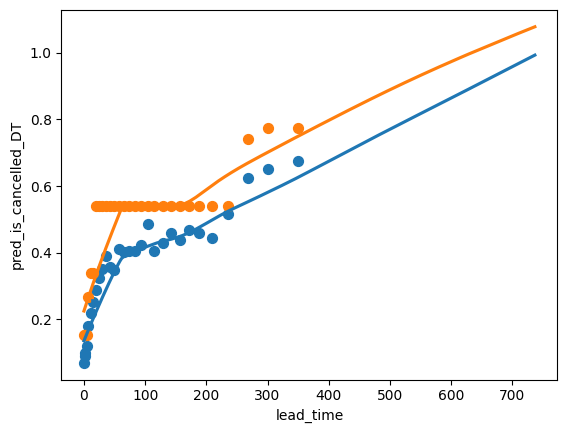

In [70]:
sns.regplot(data=tb_hotel, x='lead_time', y="pred_is_cancelled_BOO", lowess=True, x_estimator = np.mean, x_bins = 30)
sns.regplot(data=tb_hotel, x='lead_time', y="pred_is_cancelled_DT", lowess=True, x_estimator = np.mean, x_bins = 30)
# sns.scatterplot(data=tb_hotel, x='lead_time', y='pred_is_cancelled_RL')
# sns.scatterplot(data=tb_hotel, x='lead_time', y='pred_lead_time_cat')

# Exercício de Fixação:

- Ler sobre as métricas Accuracy, Precision, Recall e F1. Entender o que elas fazem, para que servem.
- Entender como elas explicam o motivo de um modelo ser bom/ruim.
- Entender como o balanceamento de amostras influencia esses scores. Será que cada modelo reage diferente ao balanceamento?

Accuracy: Métrica que representa a razão entre as instâncias classificadas corretamente sobre o total de instâncias do dataset. Não é considerada uma boa métrica para descrever o poder de predição de um modelo especialmente quando o dataset é desbalanceado, pois o modelo poderia chutar que todas as instâncias são da classe majoritária e ainda assim obter ótimos scores.

#### Definições dos tipos de erro numa classificação binária:

True Positive (TP): Instâncias cujo label conhecido é positivo e o modelo classificou como positivo tbm.

True Negative (TN): Instâncias cujo label conhecido é negativo e o modelo classificou como negativo tbm.

False Positive (FP): Instâncias cujo label conhecido é negativo e o modelo classificou como positivo.

False Negative (FN): Instâncias cujo label conhecido é positivo e o modelo classificou como negativo.

Estas 4 medidas formam a Confusion Matrix.

#### Métricas baseadas nos tipos de erro acima:

**Precision**: É a razão entre os de fato **TP** e tudo que o modelo acha que é a classe positiva **(TP + FP)**, Nos fornece um score normalizado do quão certo o modelo está ao classificar uma instância como positiva (eu classifico corretamente a classe positiva em x% das vezes!). É usado em casos onde é pior pro problema classificar algo erroneamente como positivo (FP) (campanhas de marketing ou situações de otimizar lucro ou outras variáveis). 

(Outra definição legal que vi em materiais): É usado para inciar algum tipo de ação quando se tem uma previsão positiva, por isso o exemplo da campanha de marketing,  nesse caso, precisão baixa fará com que a empresa desperdice dinheiro com clientes não interessados no produto da campanha de marketing.

**Recall**: TP/(TP + FN) É a razão entre os de fato **TP** e tudo que é **realmente** positivo no dataset mesmo o modelo tendo classificado algumas coisas erroneamente como não positivas **(TP + FN)**, Nos fornece um score normalizado do quão bom o modelo é em predizer a classe positiva (Eu consigo classificar corretamente x% das instâncias positivas do meu dataset!), por isso tbm é conhecido como true positive rate. Tbm está relacionado a "relevância de resultados" (muito valorizado em problemas de busca em e-commerce).

(Novamente a definição legal): Usado para trackear algum evento já ocorrido, por exemplo, detecção de fraudes ou identificação de doenças. Nesse caso a fraude/doença já aconteceu e é muito ruim pro problema o modelo deixar passar essas instâncias (ter FN é ruim).

Sendo a fórmula do Precision TP/(TP + FP), sabemos que o melhor score possível é 1. Pra isso acontecer, o numerador e denominador da razão precisam ser iguais, ou seja, FP precisa ser 0. Por isso a cada FP contabilizado, nosso denominador cresce e o score de precision é penalizado.

O mesmo vale para o Recall TP/(TP + FN), mas aqui o fator penalizante é a quantidade de FNs.



Mas de forma geral, um bom modelo é aquele que tem bom precision e também bom recall, por isso usa-se o F1 score (tbm normalizado) pois ele relaciona essas duas métricas juntas.

F1 = 2 * (precision*recall)/(precision + recall) 

Assim, para F1 ser 1, precision e recall precisam ser 1 tbm.

Porém no mundo real não é possível ter precision e recall perfeitos. 

Ou seja, dependendo do problema posso me preocupar ou só com o precision, ou só com o recall, ou se ambos tem a mesma importância, uso o F1 score.

#### Relação entre o balanceamento e as métricas